In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import time
import matplotlib.pyplot as plt
import json
import random
import mlflow
import mlflow.sklearn
import dagshub

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, d_model)
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = x.view(x.shape[0], -1, x.shape[-1])  # Ensure (batch_size, seq_length, feature_dim)  # Adding sequence length dimension
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Pooling over sequence dimension
        x = self.fc(x)
        return x.squeeze(-1)

In [5]:
def create_sequences_stacking_volume(data, seq_length):
    # Normalize the dataset
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    
    data['close'] = scaler_close.fit_transform(data[['close']])
    data['volume'] = scaler_volume.fit_transform(data[['volume']])
    
    # Select necessary columns
    data = data[["timestamp", "close", "volume"]]
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.sort_values(by="timestamp").reset_index(drop=True)

    # Generate sequences
    sequences, targets = [], []
    
    for i in range(len(data) - seq_length):
        seq_close = data.iloc[i:i+seq_length]["close"].values  
        seq_volume = data.iloc[i:i+seq_length]["volume"].values

        # Interleave close and volume values
        seq = np.column_stack((seq_close, seq_volume)).flatten()
        
        target = data.iloc[i + seq_length]["close"]  # Predict next close value
        
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

def create_sequences_no_volume_usage(data, seq_length):
    # Normalize only the close price
    scaler_close = MinMaxScaler()
    data['close'] = scaler_close.fit_transform(data[['close']])

    # Select necessary columns
    data = data[["timestamp", "close"]]
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.sort_values(by="timestamp").reset_index(drop=True)

    # Generate sequences
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq_close = data.iloc[i:i+seq_length]["close"].values  
        target = data.iloc[i + seq_length]["close"]  # Predicting next close value

        sequences.append(seq_close)
        targets.append(target)

    return np.array(sequences), np.array(targets)



def create_sequences_volume_addition(data, seq_length):
    # Normalize close and volume separately
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()

    data['close'] = scaler_close.fit_transform(data[['close']])
    data['volume'] = scaler_volume.fit_transform(data[['volume']])

    # Select necessary columns
    data = data[["timestamp", "close", "volume"]]
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.sort_values(by="timestamp").reset_index(drop=True)

    # Generate sequences
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq_close = data.iloc[i:i+seq_length]["close"].values  
        seq_volume = data.iloc[i:i+seq_length]["volume"].values  
        seq_combined = seq_close + seq_volume  
        target = data.iloc[i + seq_length]["close"]
        sequences.append(seq_combined)
        targets.append(target)

    return np.array(sequences), np.array(targets)


In [6]:
def data_preprocessing_stacking_volume(stock_data_dict, seq_length, sample_size=None):
    all_sequences, all_targets = [], []

    for stock, df in stock_data_dict.items():
        X, y = create_sequences_stacking_volume(df, seq_length)
        all_sequences.extend(X)
        all_targets.extend(y)

    # Convert to NumPy arrays
    all_sequences = np.array(all_sequences)
    all_targets = np.array(all_targets)

    # Randomly sample if sample_size is specified
    if sample_size and sample_size < len(all_sequences):
        indices = random.sample(range(len(all_sequences)), sample_size)
        all_sequences = all_sequences[indices]
        all_targets = all_targets[indices]

    # Train, Validation, and Test Split
    train_size = int(0.8 * len(all_sequences))
    val_size = int(0.1 * len(all_sequences))
    test_size = len(all_sequences) - train_size - val_size

    X_train, X_val, X_test = (
        all_sequences[:train_size], 
        all_sequences[train_size:train_size + val_size], 
        all_sequences[train_size + val_size:]
    )
    y_train, y_val, y_test = (
        all_targets[:train_size], 
        all_targets[train_size:train_size + val_size], 
        all_targets[train_size + val_size:]
    )
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).contiguous()
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).contiguous()
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).contiguous()
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).contiguous()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).contiguous()
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).contiguous()

    train_dataset = StockDataset(X_train_tensor, y_train_tensor)
    val_dataset = StockDataset(X_val_tensor, y_val_tensor)
    test_dataset = StockDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader


def data_preprocessing_no_volume_usage(stock_data_dict, seq_length, sample_size=None):
    all_sequences, all_targets = [], []

    for stock, df in stock_data_dict.items():
        X, y = create_sequences_no_volume_usage(df, seq_length)
        all_sequences.extend(X)
        all_targets.extend(y)

    # Convert to NumPy arrays
    all_sequences = np.array(all_sequences)
    all_targets = np.array(all_targets)

    # Randomly sample if sample_size is specified
    if sample_size and sample_size < len(all_sequences):
        indices = random.sample(range(len(all_sequences)), sample_size)
        all_sequences = all_sequences[indices]
        all_targets = all_targets[indices]

    # Train, Validation, and Test Split
    train_size = int(0.8 * len(all_sequences))
    val_size = int(0.1 * len(all_sequences))
    test_size = len(all_sequences) - train_size - val_size

    X_train, X_val, X_test = (
        all_sequences[:train_size], 
        all_sequences[train_size:train_size + val_size], 
        all_sequences[train_size + val_size:]
    )
    y_train, y_val, y_test = (
        all_targets[:train_size], 
        all_targets[train_size:train_size + val_size], 
        all_targets[train_size + val_size:]
    )
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).contiguous()
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).contiguous()
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).contiguous()
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).contiguous()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).contiguous()
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).contiguous()

    train_dataset = StockDataset(X_train_tensor, y_train_tensor)
    val_dataset = StockDataset(X_val_tensor, y_val_tensor)
    test_dataset = StockDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader


def data_preprocessing_volume_addition(stock_data_dict, seq_length, sample_size=None):
    all_sequences, all_targets = [], []

    for stock, df in stock_data_dict.items():
        X, y = create_sequences_volume_addition(df, seq_length)
        all_sequences.extend(X)
        all_targets.extend(y)

    # Convert to NumPy arrays
    all_sequences = np.array(all_sequences)
    all_targets = np.array(all_targets)

    # Randomly sample if sample_size is specified
    if sample_size and sample_size < len(all_sequences):
        indices = random.sample(range(len(all_sequences)), sample_size)
        all_sequences = all_sequences[indices]
        all_targets = all_targets[indices]

    # Train, Validation, and Test Split
    train_size = int(0.8 * len(all_sequences))
    val_size = int(0.1 * len(all_sequences))
    test_size = len(all_sequences) - train_size - val_size

    X_train, X_val, X_test = (
        all_sequences[:train_size], 
        all_sequences[train_size:train_size + val_size], 
        all_sequences[train_size + val_size:]
    )
    y_train, y_val, y_test = (
        all_targets[:train_size], 
        all_targets[train_size:train_size + val_size], 
        all_targets[train_size + val_size:]
    )
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).contiguous()
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).contiguous()
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).contiguous()
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).contiguous()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).contiguous()
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).contiguous()

    train_dataset = StockDataset(X_train_tensor, y_train_tensor)
    val_dataset = StockDataset(X_val_tensor, y_val_tensor)
    test_dataset = StockDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Time: {epoch_time:.2f} sec")
    
    return train_losses, val_losses

In [8]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

In [9]:
data_dir = "/kaggle/input/new-historical-dataset/dataset/historical_data"
stocks_symbols = pd.read_csv('/kaggle/input/new-historical-dataset/dataset/ind_nifty50list.csv')
stocks_symbols = stocks_symbols.drop(columns=['Company Name','Industry','Series','ISIN Code'])
print(stocks_symbols.head())

       Symbol
0    ADANIENT
1  ADANIPORTS
2  APOLLOHOSP
3  ASIANPAINT
4    AXISBANK


In [10]:
# Initialize LabelEncoder
le = LabelEncoder()
stocks_symbols['Symbol_Encoded'] = le.fit_transform(stocks_symbols['Symbol'])

# Create a mapping dictionary
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
mapping_df = pd.DataFrame(list(label_mapping.items()), columns=["Symbol", "Encoded_Value"])
mapping_df.to_csv("label_mapping.csv", index=False)
print(mapping_df.head())

       Symbol  Encoded_Value
0    ADANIENT              0
1  ADANIPORTS              1
2  APOLLOHOSP              2
3  ASIANPAINT              3
4    AXISBANK              4


**Stacking Volume**

In [11]:
input_dim = 8  # Number of features
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 3
dropout = 0.5
lr = 0.001
num_epochs = 100
batch_size = 64
seq_length = 4
sample_size = 1000  # Select 1000 random samples from all stocks

In [12]:
model_stacking_volume = TimeSeriesTransformer(input_dim, d_model=embed_dim, nhead=num_heads, num_layers=num_layers, dim_feedforward=ff_dim, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_stacking_volume.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [13]:
# Load and process multiple stocks
directory_path = "/kaggle/input/new-historical-dataset/dataset/historical_data"
stock_data_dict = {}

for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        symbol_name = filename.replace(".csv", "")
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        stock_data_dict[symbol_name] = df

In [ ]:
# Process all stocks together
train_loader, val_loader, test_loader = data_preprocessing_stacking_volume(stock_data_dict, seq_length, sample_size)

In [ ]:
# Train model
train_losses, val_losses = train_model(model_stacking_volume, train_loader, val_loader, criterion, optimizer, device, num_epochs)
test_loss = evaluate_model(model_stacking_volume, test_loader, criterion, device)

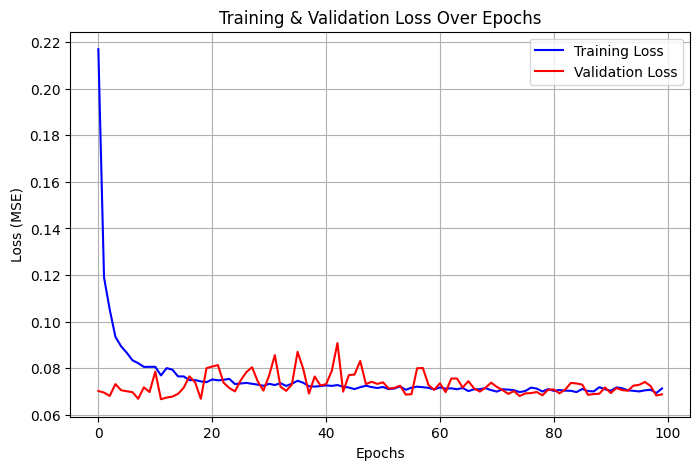

Final test loss: 0.08019455149769783


In [16]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

print("Final test loss:", test_loss)

**No_volume_usage**

In [74]:
input_dim = 8  # Number of features
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 3
dropout = 0.5
lr = 0.001
num_epochs = 100
batch_size = 64
seq_length = 8
sample_size = 1000  # Select 1000 random samples from all stocks

In [75]:
model_no_volume_usage = TimeSeriesTransformer(input_dim, d_model=embed_dim, nhead=num_heads, num_layers=num_layers, dim_feedforward=ff_dim, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_no_volume_usage.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [76]:
# Process all stocks together
train_loader, val_loader, test_loader = data_preprocessing_no_volume_usage(stock_data_dict, seq_length, sample_size)

<ipython-input-5-c1a1d7654f56>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timestamp"] = pd.to_datetime(data["timestamp"])
<ipython-input-5-c1a1d7654f56>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timestamp"] = pd.to_datetime(data["timestamp"])
<ipython-input-5-c1a1d7654f56>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [77]:
# Train model
train_losses, val_losses = train_model(model_no_volume_usage, train_loader, val_loader, criterion, optimizer, device, num_epochs)
test_loss = evaluate_model(model_no_volume_usage, test_loader, criterion, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Train Loss: 0.218224, Val Loss: 0.099864, Time: 0.40 sec


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/100, Train Loss: 0.122477, Val Loss: 0.110212, Time: 0.41 sec
Epoch 3/100, Train Loss: 0.102773, Val Loss: 0.067847, Time: 0.41 sec
Epoch 4/100, Train Loss: 0.091089, Val Loss: 0.065446, Time: 0.40 sec
Epoch 5/100, Train Loss: 0.087710, Val Loss: 0.066959, Time: 0.40 sec
Epoch 6/100, Train Loss: 0.081989, Val Loss: 0.061972, Time: 0.40 sec
Epoch 7/100, Train Loss: 0.080838, Val Loss: 0.061947, Time: 0.40 sec
Epoch 8/100, Train Loss: 0.078427, Val Loss: 0.074981, Time: 0.40 sec
Epoch 9/100, Train Loss: 0.078435, Val Loss: 0.064639, Time: 0.39 sec
Epoch 10/100, Train Loss: 0.077294, Val Loss: 0.068118, Time: 0.41 sec
Epoch 11/100, Train Loss: 0.074521, Val Loss: 0.065479, Time: 0.41 sec
Epoch 12/100, Train Loss: 0.076942, Val Loss: 0.059949, Time: 0.42 sec
Epoch 13/100, Train Loss: 0.075722, Val Loss: 0.062350, Time: 0.39 sec
Epoch 14/100, Train Loss: 0.073386, Val Loss: 0.074251, Time: 0.44 sec
Epoch 15/100, Train Loss: 0.072602, Val Loss: 0.067843, Time: 0.42 sec
Epoch 16/100, 

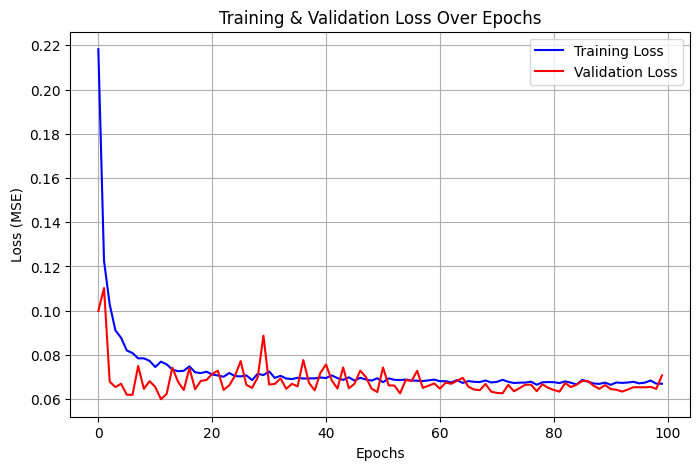

Final test loss: 0.07279539853334427


In [79]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

print("Final test loss:", test_loss)

**Volume_addition**

In [62]:
input_dim = 8  # Number of features
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 3
dropout = 0.5
lr = 0.001
num_epochs = 100
batch_size = 64
seq_length = 8
sample_size = 1000  # Select 1000 random samples from all stocks

In [63]:
model_volume_addition = TimeSeriesTransformer(input_dim, d_model=embed_dim, nhead=num_heads, num_layers=num_layers, dim_feedforward=ff_dim, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_volume_addition.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# Process all stocks together
train_loader, val_loader, test_loader = data_preprocessing_volume_addition(stock_data_dict, seq_length, sample_size)

In [ ]:
# Train model
train_losses, val_losses = train_model(model_volume_addition, train_loader, val_loader, criterion, optimizer, device, num_epochs)
test_loss = evaluate_model(model_volume_addition, test_loader, criterion, device)

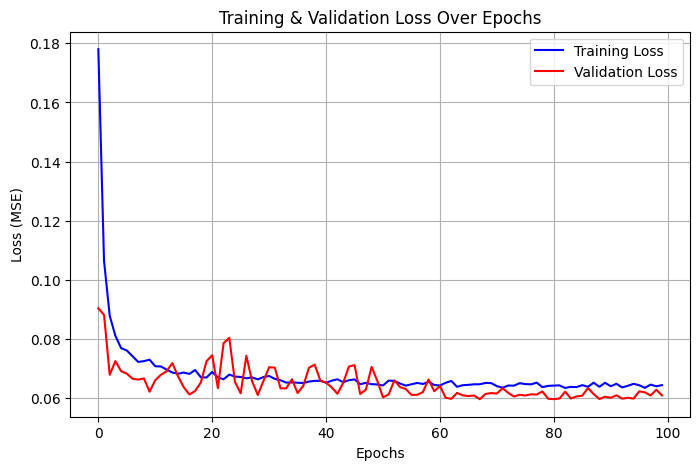

Final test loss: 0.07192585244774818


In [66]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

print("Final test loss:", test_loss)

**MLFlow**

In [45]:
dagshub.init(repo_owner='ayushkushwaha2402', repo_name='Sem-8-final-project', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=0173d05a-4188-4325-b95b-784fba842c2e&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=ad306608ae130668ac2ceab55df19e40eb0c0fc1e74eee403729764df559e489




Output()

Accessing as ayushkushwaha2402

Initialized MLflow to track repo "ayushkushwaha2402/Sem-8-final-project"

Repository ayushkushwaha2402/Sem-8-final-project initialized!

In [46]:

# Set experiment name
mlflow.set_experiment("Volume_Divergence_Experiment")

models = [model_stacking_volume, model_no_volume_usage, model_volume_addition]  # Replace with your trained models
model_names = ["model(stacked volume)", "model(no volume usage)", "model(volume addition)"]

2025/03/19 11:28:53 INFO mlflow.tracking.fluent: Experiment with name 'Volume_Divergence_Experiment' does not exist. Creating a new experiment.


In [47]:
mlflow.search_experiments()

[<Experiment: artifact_location='mlflow-artifacts:/2a3d038b959f414f869e3b03be0bf7b2', creation_time=1742383733605, experiment_id='0', last_update_time=1742383733605, lifecycle_stage='active', name='Volume_Divergence_Experiment', tags={}>]

In [80]:
# Assume testing_loss is a dictionary with model names as keys
testing_loss = {"model(stacked volume)": 0.08019455149769783, "model(no volume usage)": 0.07279539853334427, "model(volume addition)": 0.07192585244774818}

for model, name in zip(models, model_names):
    with mlflow.start_run(run_name=name):
        # Log model
        mlflow.sklearn.log_model(model, name)  # Change to appropriate log function if needed
        
        # Log testing loss
        mlflow.log_metric("testing_loss", testing_loss[name])
        
        print(f"Logged {name} to MLflow with testing loss.")

2025/03/19 11:46:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/03/19 11:46:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/19 11:46:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged model(stacked volume) to MLflow with testing loss.
🏃 View run model(stacked volume) at: https://dagshub.com/ayushkushwaha2402/Sem-8-final-project.mlflow/#/experiments/0/runs/98cc36083f834b9ba343beca7f7614f2
🧪 View experiment at: https://dagshub.com/ayushkushwaha2402/Sem-8-final-project.mlflow/#/experiments/0


2025/03/19 11:46:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/03/19 11:46:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/19 11:46:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged model(no volume usage) to MLflow with testing loss.
🏃 View run model(no volume usage) at: https://dagshub.com/ayushkushwaha2402/Sem-8-final-project.mlflow/#/experiments/0/runs/604b3a9054884cbcbfb1816d851992fe
🧪 View experiment at: https://dagshub.com/ayushkushwaha2402/Sem-8-final-project.mlflow/#/experiments/0


2025/03/19 11:46:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/03/19 11:46:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/19 11:46:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged model(volume addition) to MLflow with testing loss.
🏃 View run model(volume addition) at: https://dagshub.com/ayushkushwaha2402/Sem-8-final-project.mlflow/#/experiments/0/runs/46e00926cb0a424ab74ef8e45c467037
🧪 View experiment at: https://dagshub.com/ayushkushwaha2402/Sem-8-final-project.mlflow/#/experiments/0


In [73]:
model_scripted = torch.jit.script(model_volume_addition)
torch.jit.save(model_scripted, "stock_transformer_model.pt")

Prediction Pipeline

In [50]:
new_stock = pd.read_csv('/kaggle/input/testing-dataset/tata.csv')
stock_name = "MARUTI"

In [51]:
stock_dict = pd.read_csv('/kaggle/working/label_mapping.csv')
stock_dict.head()

,Symbol,Encoded_Value
0,ADANIENT,0
1,ADANIPORTS,1
2,APOLLOHOSP,2
3,ASIANPAINT,3
4,AXISBANK,4


In [52]:
def testing_preprocessing(data, stock_name, stock_dict):
    # Normalize close and volume separately
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()

    data['close'] = scaler_close.fit_transform(data[['close']])
    data['volume'] = scaler_volume.fit_transform(data[['volume']])

    # Select necessary columns
    data = data[["timestamp", "close", "volume"]]
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.sort_values(by="timestamp").reset_index(drop=True)

    return data

In [53]:
def create_sequence_testing(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq_close = data.iloc[i:i+seq_length]["close"].values  
        seq_volume = data.iloc[i:i+seq_length]["volume"].values  
        seq_combined = seq_close + seq_volume  
        target = data.iloc[i + seq_length]["close"]
        sequences.append(seq_combined)
        targets.append(target)

    return np.array(sequences)  # Shape: (num_samples, seq_length, input_dim=5)


In [54]:
def prediction(model, data, device, seq_length, stock_name, stock_dict, input_dim=5):
    processed_data = testing_preprocessing(data, stock_name, stock_dict)
    sequences = create_sequence_testing(processed_data, seq_length)

    # Convert to tensor & move to device
    sequences = torch.tensor(sequences, dtype=torch.float32).to(device)

    model.eval()
    predicted_values = []

    with torch.no_grad():
        for seq in sequences:  # Iterate over each sequence in the dataset
            seq = seq.unsqueeze(0)  # Add batch dimension -> Shape: (1, seq_length, input_dim)
            pred = model(seq)  # Forward pass
            predicted_values.append(pred.item())  # Store prediction

    return predicted_values  # Return all predictions in order

In [55]:
def plot_predictions(actual_csv, predicted_values, skip=5):
    # Read CSV file
    columns_to_normalize = ["close"]
    
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    
    actual_csv['close'] = scaler_close.fit_transform(actual_csv[['close']])
    actual_csv['volume'] = scaler_volume.fit_transform(actual_csv[['volume']])

    actual_csv['close'] = actual_csv['close'] 
    actual_data = actual_csv
 
    if "close" not in actual_data.columns or "timestamp" not in actual_data.columns:
        raise KeyError("Columns 'close' or 'timestamp' not found in CSV file")

    actual_data["timestamp"] = pd.to_datetime(actual_data["timestamp"])  # Ensure it's a column, not a method

    actual_prices = actual_data["close"].values[skip:]
    timestamps = actual_data["timestamp"].values[skip:]
    
    predicted_values = [pred.cpu().item() if isinstance(pred, torch.Tensor) else pred for pred in predicted_values]

    min_length = min(len(timestamps), len(predicted_values), len(actual_prices))
    timestamps = timestamps[:min_length]
    actual_prices = actual_prices[:min_length]
    predicted_values = predicted_values[:min_length]
    
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, actual_prices, label="Actual Prices", color="blue")
    plt.plot(timestamps, predicted_values, label="Predicted Prices", color="red", linestyle="dashed")
    plt.xlabel("Timestamp")
    plt.ylabel("Stock Price")
    plt.title("Actual vs Predicted Stock Prices")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [67]:
predicted_value = prediction(model_volume_addition,new_stock,device,seq_length = seq_length, stock_name = stock_name,stock_dict = stock_dict)

<ipython-input-52-cadcd09e1973>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timestamp"] = pd.to_datetime(data["timestamp"])


In [68]:
len(predicted_value)

1632

In [69]:
len(new_stock)

1640

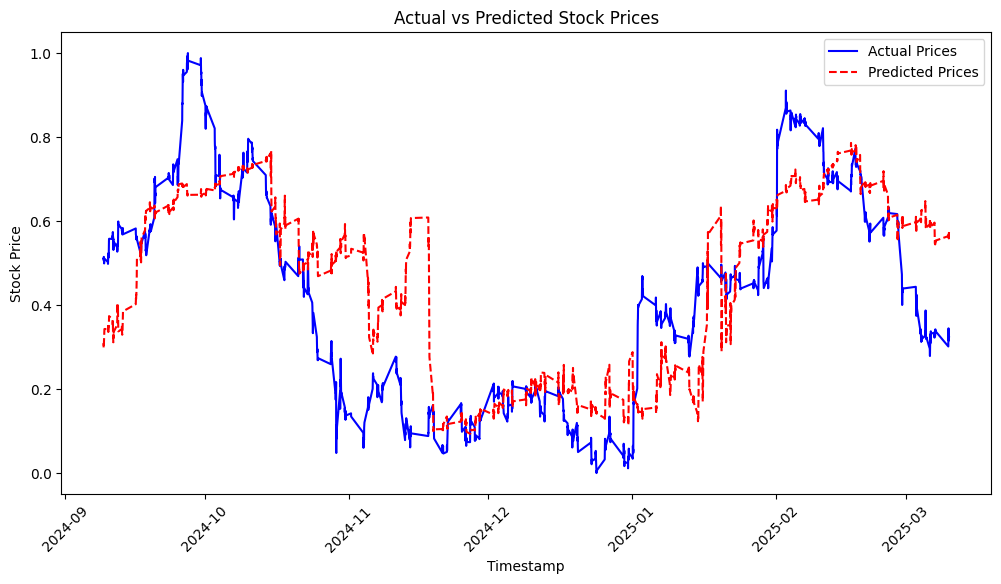

In [70]:
plot_predictions(new_stock,predicted_value)